In [11]:
!pip install imblearn
!pip install pykan

In [12]:


import numpy as np, pandas as pd, torch, torch.nn as nn
from kan import KAN
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from torch.utils.data import TensorDataset, DataLoader

In [13]:
SEQ_LEN      = 8
EPOCHS       = 100
BATCH_TRAIN  = 128
BATCH_VAL    = 128
RATIO_GRID   = [0.05,0.1,0.25,0.50,1.00]
SEED         = 42
LR           = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED); np.random.seed(SEED)

In [14]:
print(device)

cuda


In [15]:

df = pd.read_csv("ibtracscyclicfinal.csv")
df = pd.get_dummies(df, columns=["basin"], drop_first=False)
df = df.sort_values(["storm_id", "lead"])
df = df.drop_duplicates(subset=["storm_id", "lead"]).reset_index(drop=True)

storms = (df[["storm_id", "istc"]]
          .drop_duplicates()
          .reset_index(drop=True))

num_cols = ["wind","slp","pr","rh","rv","geop"]
frame_cols = (
    num_cols +
    ["sin_hour","cos_hour","sin_doy","cos_doy",
     "sin_lon","cos_lon","lat_norm",
     "lead"] +
    [c for c in df.columns if c.startswith("basin_")]
)

df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)

<ipython-input-15-2532236526>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)
<ipython-input-15-2532236526>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)
<ipython-input-15-2532236526>:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, frame_cols] = df[frame_cols].astype(np.float32)
<ipython-input-15-2532236526>:2

In [16]:
def build_xy(frame_df):
    xs, ys = [], []
    dbase  = len(frame_cols)
    for _, g in frame_df.groupby("storm_id"):
        g = g.sort_values("lead").tail(SEQ_LEN)
        arr = g[frame_cols].to_numpy(np.float32)
        if arr.shape[0] >= SEQ_LEN:
            arr_processed = arr[-SEQ_LEN:, :]
        else:
            padding_rows = SEQ_LEN - arr.shape[0]
            padding = np.zeros((padding_rows, dbase), dtype=np.float32)
            arr_processed = np.concatenate((padding, arr), axis=0) # Pad at the beginning
        xs.append(arr.reshape(-1))
        ys.append(g["istc"].iloc[-1])
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

In [17]:

train_ids, temp_ids, y_train_g, y_temp_g = train_test_split(
        storms["storm_id"], storms["istc"],
        test_size=0.30, stratify=storms["istc"],
        random_state=SEED)

val_ids,  test_ids, y_val_g, y_test_g = train_test_split(
        temp_ids, y_temp_g,
        test_size=0.50, stratify=y_temp_g,
        random_state=SEED)

train_df = df[df["storm_id"].isin(train_ids)].reset_index(drop=True)
val_df   = df[df["storm_id"].isin(val_ids )].reset_index(drop=True)
test_df  = df[df["storm_id"].isin(test_ids)].reset_index(drop=True)

X_train, y_train = build_xy(train_df)
X_val,   y_val   = build_xy(val_df)
X_test,  y_test  = build_xy(test_df)

# scale on train only
scaler  = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)


In [18]:
SEQ_LEN     = 8
N_FEAT      = len(frame_cols)
flat_names  = []

for t in range(SEQ_LEN):
    step_tag = f"t-{SEQ_LEN-1-t}"
    for f in frame_cols:
        flat_names.append(f"{f}_{step_tag}")

assert len(flat_names) == X_train.shape[1]
for name in flat_names:
    print(name)


wind_t-7
slp_t-7
pr_t-7
rh_t-7
rv_t-7
geop_t-7
sin_hour_t-7
cos_hour_t-7
sin_doy_t-7
cos_doy_t-7
sin_lon_t-7
cos_lon_t-7
lat_norm_t-7
lead_t-7
basin_1.0_t-7
basin_2.0_t-7
basin_3.0_t-7
basin_4.0_t-7
basin_5.0_t-7
basin_6.0_t-7
basin_7.0_t-7
wind_t-6
slp_t-6
pr_t-6
rh_t-6
rv_t-6
geop_t-6
sin_hour_t-6
cos_hour_t-6
sin_doy_t-6
cos_doy_t-6
sin_lon_t-6
cos_lon_t-6
lat_norm_t-6
lead_t-6
basin_1.0_t-6
basin_2.0_t-6
basin_3.0_t-6
basin_4.0_t-6
basin_5.0_t-6
basin_6.0_t-6
basin_7.0_t-6
wind_t-5
slp_t-5
pr_t-5
rh_t-5
rv_t-5
geop_t-5
sin_hour_t-5
cos_hour_t-5
sin_doy_t-5
cos_doy_t-5
sin_lon_t-5
cos_lon_t-5
lat_norm_t-5
lead_t-5
basin_1.0_t-5
basin_2.0_t-5
basin_3.0_t-5
basin_4.0_t-5
basin_5.0_t-5
basin_6.0_t-5
basin_7.0_t-5
wind_t-4
slp_t-4
pr_t-4
rh_t-4
rv_t-4
geop_t-4
sin_hour_t-4
cos_hour_t-4
sin_doy_t-4
cos_doy_t-4
sin_lon_t-4
cos_lon_t-4
lat_norm_t-4
lead_t-4
basin_1.0_t-4
basin_2.0_t-4
basin_3.0_t-4
basin_4.0_t-4
basin_5.0_t-4
basin_6.0_t-4
basin_7.0_t-4
wind_t-3
slp_t-3
pr_t-3
rh_t-3
rv_t-

In [19]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing  import MinMaxScaler
SEQ_LEN = 8

In [20]:
X_mm  = MinMaxScaler().fit_transform(X_train)
chi_s = chi2(X_mm, y_train)[0]
print(chi_s.shape)        # (168,)

mi_s  = mutual_info_classif(X_train, y_train, random_state=42)  # (168,)
print(mi_s.shape)
print(len(frame_cols))

rank_df = pd.DataFrame({
    'feature' : flat_names,           # length 168
    'mutinfo' : mi_s
})
rank_df['mi_rank']  = rank_df['mutinfo'].rank(ascending=False)
rank_df = rank_df.sort_values('mi_rank').reset_index(drop=True)
display(rank_df.head(15))


(168,)
(168,)
21


,feature,mutinfo,mi_rank
0,wind_t-0,0.008862,1.0
1,wind_t-3,0.008620,2.0
2,wind_t-5,0.008492,3.0
3,wind_t-2,0.008277,4.0
4,slp_t-6,0.008263,5.0
5,slp_t-3,0.008097,6.0
6,slp_t-5,0.007786,7.0
7,rv_t-0,0.007712,8.0
8,wind_t-4,0.007595,9.0
9,slp_t-7,0.007307,10.0


In [21]:
N_TOP_FEATURES = 10
top_15_features = rank_df.head(N_TOP_FEATURES)
print(f"Top {N_TOP_FEATURES} features selected based on Mutual Information:")
print(top_15_features)


Top 10 features selected based on Mutual Information:
    feature   mutinfo  mi_rank
0  wind_t-0  0.008862      1.0
1  wind_t-3  0.008620      2.0
2  wind_t-5  0.008492      3.0
3  wind_t-2  0.008277      4.0
4   slp_t-6  0.008263      5.0
5   slp_t-3  0.008097      6.0
6   slp_t-5  0.007786      7.0
7    rv_t-0  0.007712      8.0
8  wind_t-4  0.007595      9.0
9   slp_t-7  0.007307     10.0


In [22]:
chosen_features = [
    "rv_t-7",
    "slp_t-0",
    "sin_hour_t-0",
    "wind_t-7",
    "pr_t-0",
    "cos_hour_t-0",
    "pr_t-2",
    "wind_t-1",
    "wind_t-0",
    "wind_t-4"
]

In [23]:
selected_feature_mask = np.array(
        [name in chosen_features for name in flat_names]
)
selected_feature_indices = np.where(selected_feature_mask)[0]

print("Columns selected (0-based):", selected_feature_indices)

Columns selected (0-based): [  0   4  63 107 126 147 148 149 153 154]


In [24]:
from sklearn.metrics import precision_score, recall_score


In [25]:
results_per_ratio_and_threshold = []
THRESHOLDS_TO_REPORT = np.arange(0.1, 1.0, 0.1) # 0.1, 0.2, ..., 0.9
FINAL_RATIO = 0.25

SMOTE_RATIO = max(FINAL_RATIO, 0.01)
smote = SMOTE(sampling_strategy=SMOTE_RATIO, k_neighbors=3, random_state=SEED)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

m       = (y_sm == 1).sum()
M_sm    = (y_sm == 0).sum()
cur_rat = m / M_sm

if FINAL_RATIO < cur_rat:
    M_target  = int(m / FINAL_RATIO)
    rus_ratio = m / M_target
    rus = RandomUnderSampler(sampling_strategy=rus_ratio, random_state=SEED)
    X_bal, y_bal = rus.fit_resample(X_sm, y_sm)
else:
    X_bal, y_bal = X_sm, y_sm

print(f"Class distribution after Balancing: {np.bincount(y_bal.astype(int))}, ratio: {(y_bal == 1).sum() / (y_bal == 0).sum():.3f}")


X_bal_selected = X_bal[:, selected_feature_mask]
X_val_selected = X_val[:, selected_feature_mask]
print(f"Shape of training data after feature selection: {X_bal_selected.shape}")

train_ds = TensorDataset(torch.tensor(X_bal_selected), torch.tensor(y_bal))
val_ds   = TensorDataset(torch.tensor(X_val_selected), torch.tensor(y_val))
train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_VAL, shuffle=False)


model = KAN(width=[X_bal_selected.shape[1],1], grid=10, k=3, seed=2024, device=device).to(device)
print(f"Model created with input width: {X_bal_selected.shape[1]}")
print("Total parameters before pruning:",
  sum(p.numel() for p in model.parameters()))

model.speed()
pos_weight = torch.tensor([(y_train==0).sum()/(y_train==1).sum()],
                          dtype=torch.float32, device=device)
criterion  = nn.BCEWithLogitsLoss()
optim      = torch.optim.Adam(model.parameters(),
                            lr=LR,weight_decay=1e-3)



patience = 30  #
min_delta = 0.001
best_val_f1 = -float('inf')
best_val_precision = -float('inf')
best_val_recall = -float('inf')
best_val_threshold = 0.0
epochs_no_improve = 0

N_MONITOR = 10
THRESH    = 0.5
lamb      = 3.0
reg_metric= "edge_forward_sum"



def _eval_fixed_thresholds(model,loader, thresholds_to_report):
    model.eval()
    y_t, y_p, running_loss = [], [], 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb).squeeze()
            running_loss += criterion(logits, yb).item()
            prob = torch.sigmoid(logits).cpu().numpy()
            y_p.append(prob); y_t.append(yb.cpu().numpy())
    y_t = np.concatenate(y_t); y_p = np.concatenate(y_p)

    metrics_at_thresholds = []
    for t in thresholds_to_report:
        y_h_temp  = (y_p >= t).astype(int)
        f1_val = f1_score(y_t, y_h_temp, zero_division=0)
        precision_val = precision_score(y_t, y_h_temp, zero_division=0)
        recall_val = recall_score(y_t, y_h_temp, zero_division=0)
        pr_val  = average_precision_score(y_t, y_p)

        metrics_at_thresholds.append({
            'threshold': t,
            'f1': f1_val,
            'precision': precision_val,
            'recall': recall_val,
            'pr': pr_val
        })
    return running_loss / len(loader), metrics_at_thresholds


for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optim.zero_grad()
        loss = criterion(model(xb).squeeze(), yb)
        loss  += lamb * model.reg(reg_metric,
                                lamb_l1     = 2.0,
                                lamb_entropy= 3.0,
                                lamb_coef   = 0.0,
                                lamb_coefdiff = 0.0)
        loss.backward()
        optim.step()
        epoch_loss += loss.item()

    if (epoch + 1) % N_MONITOR == 0 or epoch == EPOCHS - 1:
        train_loss, train_metrics_at_thresholds = _eval_fixed_thresholds(model,train_loader, THRESHOLDS_TO_REPORT)
        val_loss, val_metrics_at_thresholds = _eval_fixed_thresholds(model,val_loader, THRESHOLDS_TO_REPORT)
        current_val_f1_for_early_stop = -float('inf')
        current_val_f1_threshold = 0.0
        current_p_for_best_f1 = 0.0
        current_r_for_best_f1 = 0.0
        for m in val_metrics_at_thresholds:
            if m['f1'] > current_val_f1_for_early_stop:
                current_val_f1_for_early_stop = m['f1']
                current_val_f1_threshold = m['threshold']
                current_p_for_best_f1 = m['precision']
                current_r_for_best_f1 = m['recall']
        print(f"\nEpoch {epoch+1:3d} | train loss {train_loss:.4f} || val loss {val_loss:.4f}")
        print(f"       --- Train Metrics ---")
        for m in train_metrics_at_thresholds:
            print(f"       Thresh {m['threshold']:.1f}: P {m['precision']:.3f} R {m['recall']:.3f} F1 {m['f1']:.3f} PR-AUC {m['pr']:.3f}")
        print(f"       --- Validation Metrics (Best Val F1 this epoch: {current_val_f1_for_early_stop:.3f}) ---")
        for m in val_metrics_at_thresholds:
            print(f"       Thresh {m['threshold']:.1f}: P {m['precision']:.3f} R {m['recall']:.3f} F1 {m['f1']:.3f} PR-AUC {m['pr']:.3f}")


        if current_val_f1_for_early_stop > best_val_f1 + min_delta:
            best_val_f1 = current_val_f1_for_early_stop
            best_val_threshold = current_val_f1_threshold
            best_val_precision = current_p_for_best_f1
            best_val_recall = current_r_for_best_f1
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} as validation F1 did not improve for {patience} epochs.")
                break


model.load_state_dict(best_state)
model = model.prune_node(threshold=1e-3)
print(f"Pruned {model} edges (threshold 5e-4)")
print("Total parameters after pruning:",
  sum(p.numel() for p in model.parameters()))

fine_opt = torch.optim.Adam(model.parameters(),
                            lr=LR * 0.1, weight_decay=1e-3)
for _ in range(5):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        fine_opt.zero_grad()
        loss = criterion(model(xb).squeeze(), yb)
        loss.backward(); fine_opt.step()

_, final_val_metrics = _eval_fixed_thresholds(model,
    val_loader, THRESHOLDS_TO_REPORT)


results_per_ratio_and_threshold.append({
    'FINAL_RATIO':  FINAL_RATIO,
    'best_val_f1':  best_val_f1,
    'best_thr':     best_val_threshold,
    'best_val_precision': best_val_precision,
    'best_val_recall': best_val_recall,
    'val_metrics':  final_val_metrics
})


print("\n--- Training Complete ---")
print("Results for different FINAL_RATIO values:")
for res in results_per_ratio_and_threshold:
  print(f"\nRatio: {res['FINAL_RATIO']}, Best Final Val F1: {res['best_val_f1']:.3f} "
        f"(P: {res['best_val_precision']:.3f}, R: {res['best_val_recall']:.3f}) @ Thresh {res['best_thr']:.1f}")
  print("Final Validation Metrics for this ratio:")
  for m in res['val_metrics']:
      print(f"  Thresh {m['threshold']:.1f}: P {m['precision']:.3f} R {m['recall']:.3f} F1 {m['f1']:.3f} PR-AUC {m['pr']:.3f}")


Class distribution after Balancing: [11085  2771], ratio: 0.250
Shape of training data after feature selection: (13856, 10)
checkpoint directory created: ./model
saving model version 0.0
Model created with input width: 10
Total parameters before pruning: 384

Epoch  10 | train loss 0.3068 || val loss 0.1608
       --- Train Metrics ---
       Thresh 0.1: P 0.344 R 0.931 F1 0.503 PR-AUC 0.753
       Thresh 0.2: P 0.551 R 0.798 F1 0.652 PR-AUC 0.753
       Thresh 0.3: P 0.680 R 0.662 F1 0.671 PR-AUC 0.753
       Thresh 0.4: P 0.759 R 0.549 F1 0.637 PR-AUC 0.753
       Thresh 0.5: P 0.823 R 0.463 F1 0.592 PR-AUC 0.753
       Thresh 0.6: P 0.882 R 0.396 F1 0.546 PR-AUC 0.753
       Thresh 0.7: P 0.927 R 0.323 F1 0.479 PR-AUC 0.753
       Thresh 0.8: P 0.962 R 0.246 F1 0.391 PR-AUC 0.753
       Thresh 0.9: P 0.987 R 0.160 F1 0.275 PR-AUC 0.753
       --- Validation Metrics (Best Val F1 this epoch: 0.312) ---
       Thresh 0.1: P 0.019 R 0.833 F1 0.037 PR-AUC 0.271
       Thresh 0.2: P 0.036

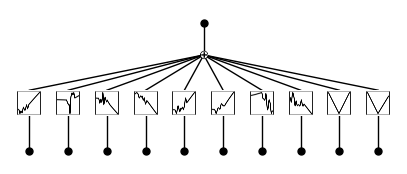

In [26]:
model.plot(beta=100)

In [27]:

print(f"Number of KAN layers in act_fun: {len(model.act_fun)}")

for i, kan_layer in enumerate(model.act_fun):
    print(f"\nDetails for act_fun Layer {i}:")
    print(kan_layer)
    if hasattr(kan_layer, 'spline_weight'):
        print(f"  - Shape of spline_weight tensor: {kan_layer.spline_weight.shape}")
    if hasattr(kan_layer, 'base_weight'):
        print(f"  - Shape of base_weight tensor: {kan_layer.base_weight.shape}")




print(f"Number of layers in symbolic_fun: {len(model.symbolic_fun)}")

for i, symbolic_layer in enumerate(model.symbolic_fun):
    print(f"\nDetails for symbolic_fun Layer {i}:")
    print(symbolic_layer)


    if hasattr(symbolic_layer, 'funs'):
        print(f"  - Number of symbolic functions found: {len(symbolic_layer.funs)}")



model.save_act = True
with torch.no_grad():
    _ = model(torch.tensor(X_val,
                           dtype=torch.float32,
                           device=device))   # 1 fresh pass
model.auto_symbolic(r2_threshold = 0.999,
        weight_simple = 4.0)          # now works

formula = model.symbolic_formula()[0][0]
print(f"\n\n--- Symbolic Formula ---")
print(formula)



--- Inspecting 'act_fun' (Activation Function Layers) ---
Number of KAN layers in act_fun: 1

Details for act_fun Layer 0:
KANLayer(
  (base_fun): SiLU()
)


--- Inspecting 'symbolic_fun' (Symbolic Function Layers) ---
Number of layers in symbolic_fun: 1

Details for symbolic_fun Layer 0:
Symbolic_KANLayer()
  - Number of symbolic functions found: 1
For (0,0,0) the best fit was 0, but r^2 = 0.0 and this is lower than 0.999. This edge was omitted, keep training or try a different threshold.
For (0,1,0) the best fit was 0, but r^2 = 0.0 and this is lower than 0.999. This edge was omitted, keep training or try a different threshold.
For (0,2,0) the best fit was 0, but r^2 = 0.0 and this is lower than 0.999. This edge was omitted, keep training or try a different threshold.
For (0,3,0) the best fit was 0, but r^2 = 0.0 and this is lower than 0.999. This edge was omitted, keep training or try a different threshold.
For (0,4,0) the best fit was 0, but r^2 = 0.0 and this is lower than 0.999.

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=79e3b56dce491d7949066cceeef47ec2284319eb493a4bb78ea0cdc2ee5d72fd
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime



--- Starting LIME Analysis for FINAL_RATIO: 0.25 ---
Found instance for False Negative: Yes
Found instance for False Positive: Yes
Found instance for True Negative:  Yes
Found instance for True Positive:  Yes

--- Explaining: True Positive (Validation Set Index: 55) ---
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.0017, Is TC: 0.9983


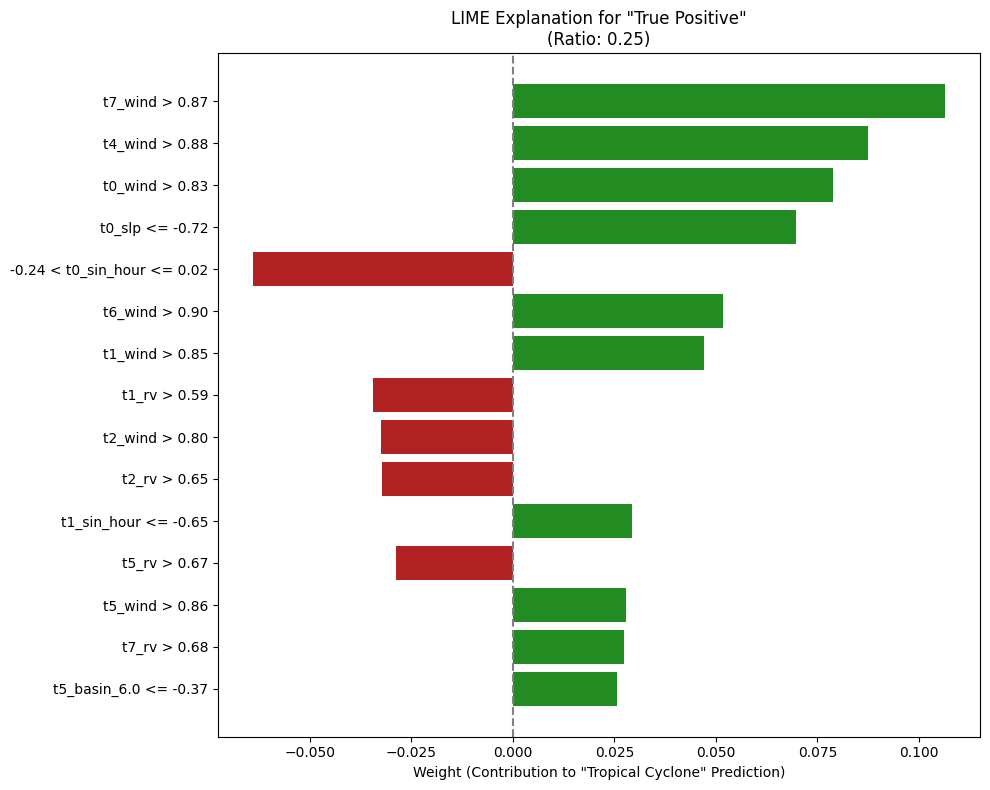


--- Explaining: True Negative (Validation Set Index: 0) ---
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.9678, Is TC: 0.0322


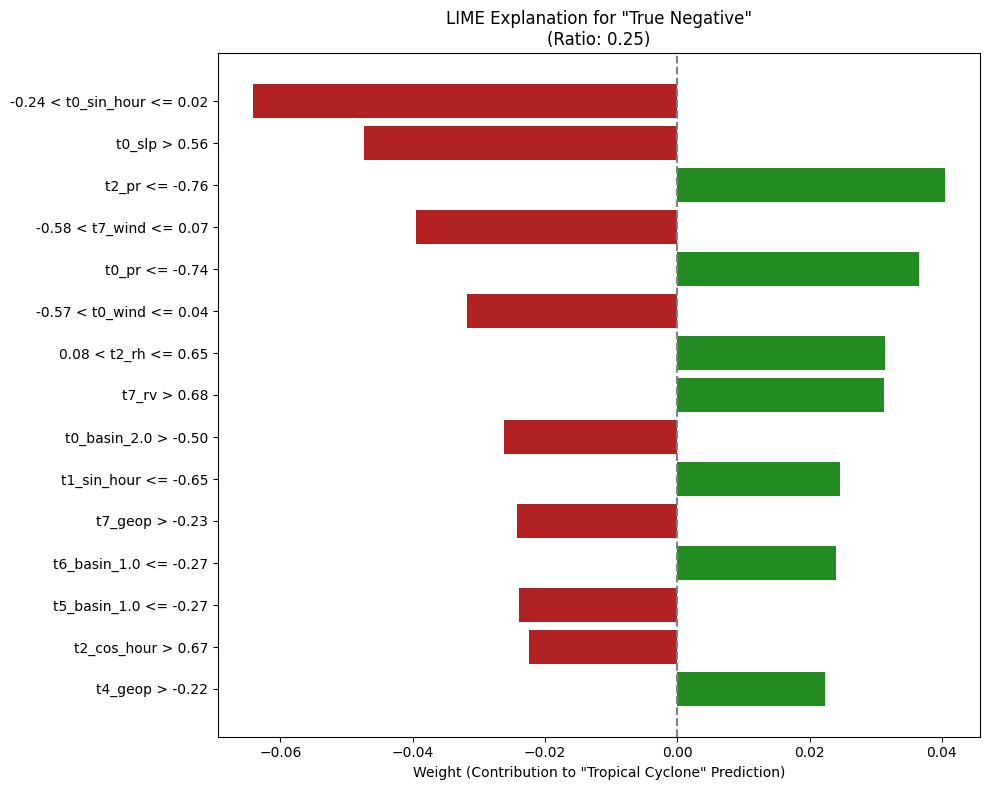


--- Explaining: False Positive (Validation Set Index: 130) ---
True Label: Not Tropical Cyclone
Model Prediction Probs -> Not TC: 0.1599, Is TC: 0.8401


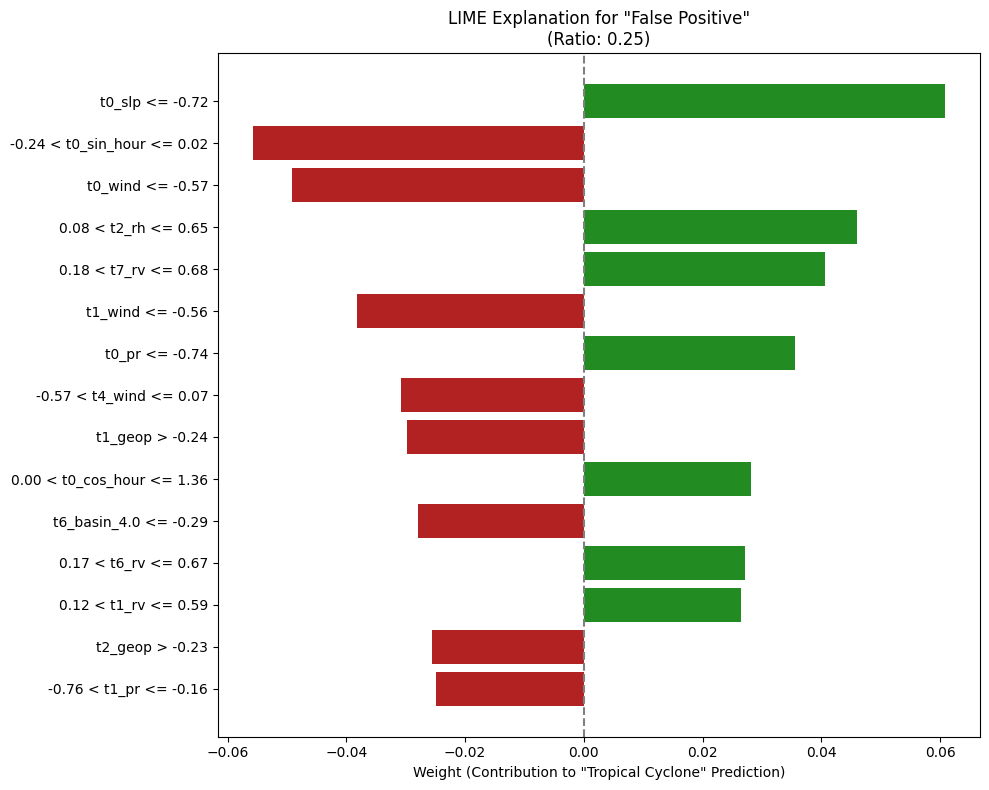


--- Explaining: False Negative (Validation Set Index: 52) ---
True Label: Tropical Cyclone
Model Prediction Probs -> Not TC: 0.7404, Is TC: 0.2596


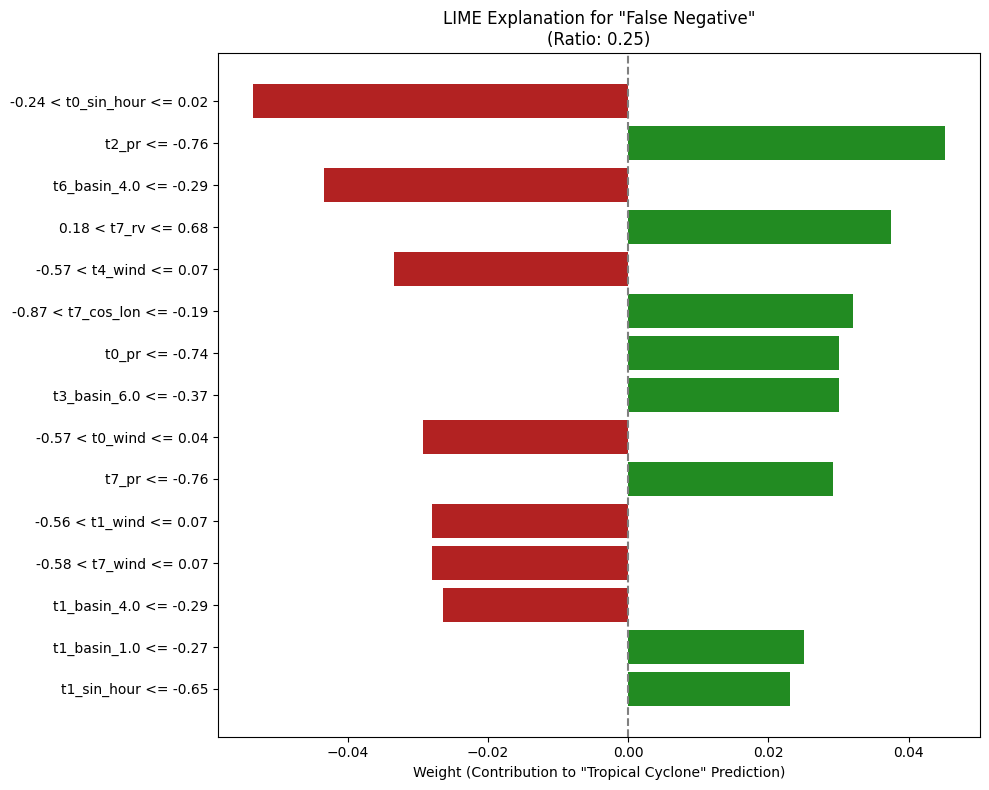

--- LIME Analysis for FINAL_RATIO: 0.25 Complete ---



In [ ]:


import lime
import lime.lime_tabular
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_val_pred_proba = []
with torch.no_grad():
    for xb, yb in val_loader:
        logits = model(xb.to(device)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        y_val_pred_proba.append(probs)
y_val_pred_proba = np.concatenate(y_val_pred_proba)

PREDICTION_THRESHOLD = best_val_threshold
y_val_pred_class = (y_val_pred_proba >= PREDICTION_THRESHOLD).astype(int)
y_val_true = y_val
false_neg_idx = np.where((y_val_true == 1) & (y_val_pred_class == 0))[0]
false_pos_idx = np.where((y_val_true == 0) & (y_val_pred_class == 1))[0]
true_neg_idx  = np.where((y_val_true == 0) & (y_val_pred_class == 0))[0]
true_pos_idx  = np.where((y_val_true == 1) & (y_val_pred_class == 1))[0]

fn_idx = false_neg_idx[0] if len(false_neg_idx) > 0 else None
fp_idx = false_pos_idx[0] if len(false_pos_idx) > 0 else None
tn_idx = true_neg_idx[0] if len(true_neg_idx) > 0 else None
tp_idx = true_pos_idx[0] if len(true_pos_idx) > 0 else None

print(f"Found instance for False Negative: {'Yes' if fn_idx is not None else 'No'}")
print(f"Found instance for False Positive: {'Yes' if fp_idx is not None else 'No'}")
print(f"Found instance for True Negative:  {'Yes' if tn_idx is not None else 'No'}")
print(f"Found instance for True Positive:  {'Yes' if tp_idx is not None else 'No'}")



def lime_predict_fn(numpy_array_2d):
    model.eval()
    with torch.no_grad():
        tensor_input = torch.from_numpy(numpy_array_2d).float().to(device)
        logits = model(tensor_input)
        probabilities = torch.sigmoid(logits).cpu().numpy()
        return np.hstack((1 - probabilities, probabilities))

feature_names = [f"t{i//len(frame_cols)}_{frame_cols[i%len(frame_cols)]}" for i in range(X_train.shape[1])]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_bal,
    feature_names=feature_names,
    class_names=['Not Tropical Cyclone', 'Tropical Cyclone'],
    mode='classification'
)

def explain_instance_with_plot(title, instance_idx):
    if instance_idx is None:
        print(f"\n--- {title}: No instance found to explain. ---")
        return

    print(f"\n--- Explaining: {title} (Validation Set Index: {instance_idx}) ---")

    instance_to_explain = X_val[instance_idx]

    pred_probs = lime_predict_fn(instance_to_explain.reshape(1, -1))[0]
    true_label_text = 'Tropical Cyclone' if y_val_true[instance_idx] == 1 else 'Not Tropical Cyclone'

    print(f"True Label: {true_label_text}")
    print(f"Model Prediction Probs -> Not TC: {pred_probs[0]:.4f}, Is TC: {pred_probs[1]:.4f}")

    explanation = explainer.explain_instance(
        instance_to_explain,
        lime_predict_fn,
        num_features=15,
        labels=(1,)
    )

    exp_list = explanation.as_list(label=1)
    exp_list.reverse()

    fig, ax = plt.subplots(figsize=(10, 8))

    feature_conditions = [x[0] for x in exp_list]
    feature_weights = [x[1] for x in exp_list]

    colors = ['forestgreen' if w > 0 else 'firebrick' for w in feature_weights]

    positions = np.arange(len(exp_list))
    ax.barh(positions, feature_weights, align='center', color=colors)

    ax.set_yticks(positions)
    ax.set_yticklabels(feature_conditions)
    ax.set_title(f'LIME Explanation for "{title}"\n(Ratio: {FINAL_RATIO})')
    ax.set_xlabel('Weight (Contribution to "Tropical Cyclone" Prediction)')
    ax.axvline(x=0, color='grey', linestyle='--')

    fig.tight_layout()
    plt.show()

explain_instance_with_plot("True Positive", tp_idx)
explain_instance_with_plot("True Negative", tn_idx)
explain_instance_with_plot("False Positive", fp_idx)
explain_instance_with_plot("False Negative", fn_idx)

print(f"--- LIME Analysis for FINAL_RATIO: {FINAL_RATIO} Complete ---\n")



--- Starting SHAP Analysis for FINAL_RATIO: 0.25 ---
Calculating SHAP values on validation instances using KernelExplainer (this may take a moment)...


  0%|          | 0/1000 [00:00<?, ?it/s]

SHAP values calculated.

Generating SHAP Global Feature Importance Plot (Bar)...


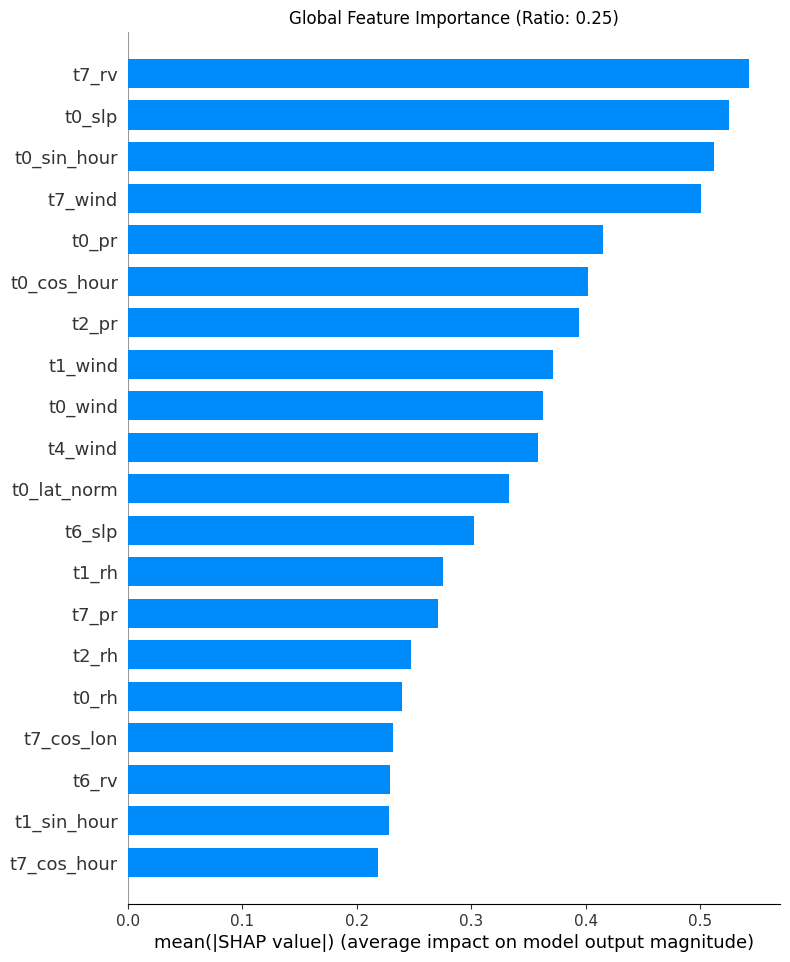


Generating SHAP Feature Impact Plot (Beeswarm)...


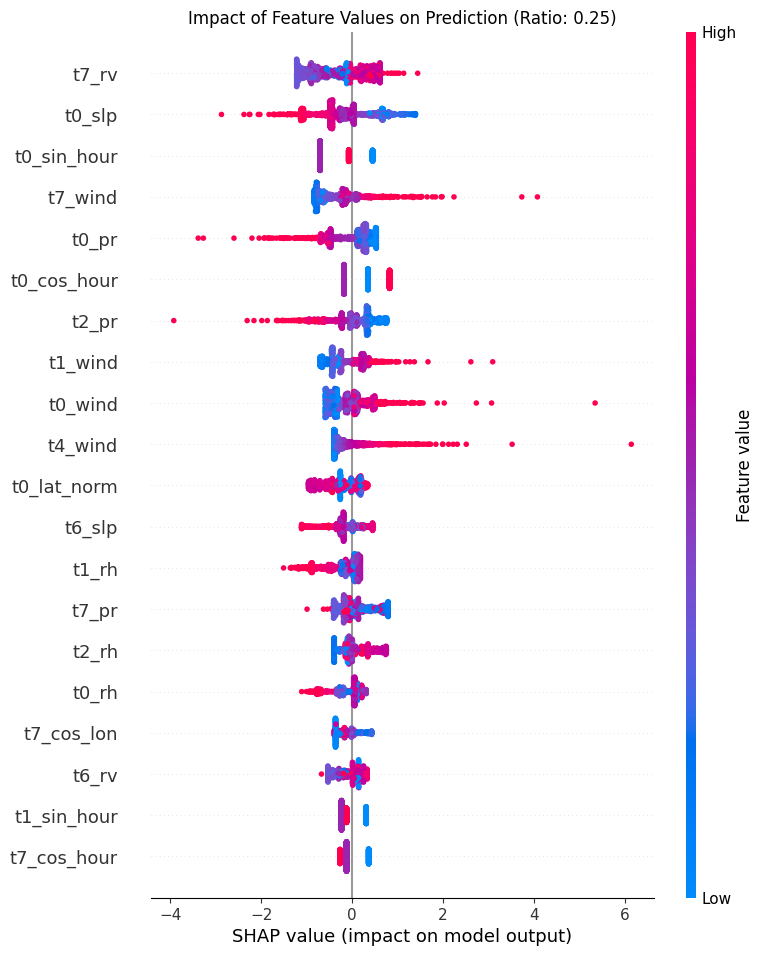


Generating SHAP Force Plot for the first validation instance...


<Figure size 640x480 with 0 Axes>

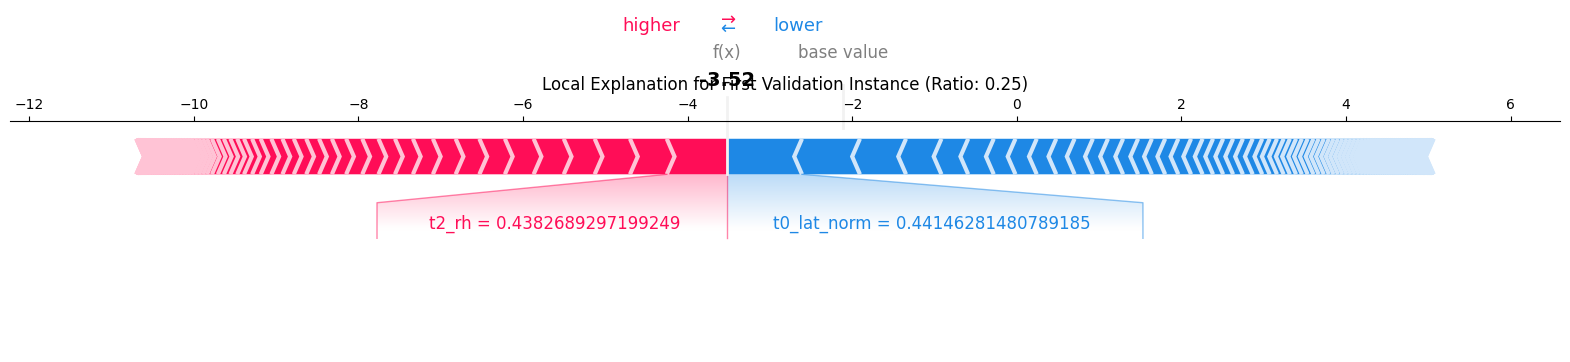

--- SHAP Analysis for FINAL_RATIO: 0.25 Complete ---



In [ ]:

import shap
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

print(f"\n--- Starting SHAP Analysis for FINAL_RATIO: {FINAL_RATIO} ---")

background_data_np = X_bal[np.random.choice(X_bal.shape[0], 50, replace=False)]


instances_to_explain_np = X_val[:1000]


def model_predict_for_shap(numpy_array):
    model.eval()
    with torch.no_grad():
        tensor_input = torch.from_numpy(numpy_array).float().to(device)
        logits = model(tensor_input)

        return logits.squeeze(-1).cpu().numpy()

background_data_summary = shap.kmeans(background_data_np, 10)
explainer = shap.KernelExplainer(model_predict_for_shap, background_data_summary)



print("Calculating SHAP values on validation instances using KernelExplainer (this may take a moment)...")

shap_values = explainer.shap_values(instances_to_explain_np, nsamples="auto")
print("SHAP values calculated.")

feature_names = [f"t{i//len(frame_cols)}_{frame_cols[i%len(frame_cols)]}" for i in range(X_train.shape[1])]

instances_df = pd.DataFrame(instances_to_explain_np, columns=feature_names)



print("\nGenerating SHAP Global Feature Importance Plot (Bar)...")
plt.figure()
shap.summary_plot(shap_values, instances_df, plot_type="bar", show=False)
plt.title(f"Global Feature Importance (Ratio: {FINAL_RATIO})")
plt.show()


print("\nGenerating SHAP Feature Impact Plot (Beeswarm)...")
plt.figure()
shap.summary_plot(shap_values, instances_df, show=False)
plt.title(f"Impact of Feature Values on Prediction (Ratio: {FINAL_RATIO})")
plt.show()

print(f"\nGenerating SHAP Force Plot for the first validation instance...")


plt.figure()
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    instances_df.iloc[0,:],
    matplotlib=True,
    show=False
)
plt.title(f"Local Explanation for First Validation Instance (Ratio: {FINAL_RATIO})")
plt.show()

print(f"--- SHAP Analysis for FINAL_RATIO: {FINAL_RATIO} Complete ---\n")
